# U-Net++ Change Detection Training Notebook
This notebook trains a U-Net++ model for change detection using A/B/label folders for train, val, and test. It includes installation, data loading, training with early stopping, saving metrics, and displaying results.

## Assignment Compliance (Segmentation)
- Problem: Change detection (binary segmentation of change mask)
- Model: U-Net++ (recent variant, deeper variant over base U-Net)
- Epochs: Min 50 with early stopping (patience 10)
- Data: Using existing train / val / test folders exactly as provided (no re-splitting enforced).
- Metrics tracked: IoU, Dice, Precision, Recall, F1, Accuracy, Loss + confusion matrix (pixel-wise)
- Outputs: Metric plots, sample predictions, parameter count, GFLOPs, saved best weights.
- Saved artifacts: best_model.pth, training_history.csv, test_metrics.csv, confusion_matrix.txt, prediction PNGs.


In [1]:
# Install all required packages
!pip install segmentation-models-pytorch torch torchvision albumentations scikit-learn pandas tqdm thop torchinfo matplotlib seaborn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.2 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.8 MB/s eta 0:00:00:00:0100:01


In [2]:
# Imports & Setup for custom U-Net++ training (from scratch style like Siamese notebook)
import os, random, math
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Device & Reproducibility
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
print(f"Using device: {DEVICE}")

# Loss components (Dice + BCE)
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth
    def forward(self, preds, targets):
        # preds: probabilities after sigmoid, targets: binary
        preds = preds.contiguous()
        targets = targets.contiguous()
        intersection = (preds * targets).sum(dim=(2,3))
        denom = preds.sum(dim=(2,3)) + targets.sum(dim=(2,3))
        dice = (2 * intersection + self.smooth) / (denom + self.smooth)
        return 1 - dice.mean()

def combined_loss(logits, targets, bce_w=0.6, dice_w=0.4):
    bce = nn.BCEWithLogitsLoss()(logits, targets)
    probs = torch.sigmoid(logits)
    dloss = DiceLoss()(probs, targets)
    return bce_w * bce + dice_w * dloss

@torch.no_grad()
def batch_metrics(logits, targets, thresh=0.5):
    probs = torch.sigmoid(logits)
    preds = (probs >= thresh).float()
    p = preds.view(-1).cpu().numpy()
    t = targets.view(-1).cpu().numpy()
    # Confusion components
    cm = confusion_matrix(t, p, labels=[0,1]) if (t.sum()>0 or p.sum()>0) else np.array([[len(t),0],[0,0]])
    if cm.shape == (2,2):
        tn, fp, fn, tp = cm.ravel()
    else:  # degenerate
        tn = fp = fn = tp = 0
    eps = 1e-8
    iou = tp / (tp + fp + fn + eps)
    dice = (2*tp) / (2*tp + fp + fn + eps)
    precision = tp / (tp + fp + eps) if (tp+fp)>0 else 0.0
    recall = tp / (tp + fn + eps) if (tp+fn)>0 else 0.0
    f1 = 2*precision*recall/(precision+recall+eps) if (precision+recall)>0 else 0.0
    acc = (tp + tn) / (tp + tn + fp + fn + eps)
    return dict(tp=int(tp), fp=int(fp), fn=int(fn), tn=int(tn), iou=float(iou), dice=float(dice), precision=float(precision), recall=float(recall), f1=float(f1), acc=float(acc))

class EarlyStopping:
    def __init__(self, patience=15, min_delta=1e-4, restore_best=True, min_epochs=50):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best = restore_best
        self.best_loss = None
        self.counter = 0
        self.best_state = None
        self.min_epochs = min_epochs
    def __call__(self, epoch, current_loss, model):
        if self.best_loss is None or (self.best_loss - current_loss) > self.min_delta:
            self.best_loss = current_loss
            self.counter = 0
            if self.restore_best:
                self.best_state = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}
        else:
            self.counter += 1
        if epoch+1 < self.min_epochs:
            return False
        if self.counter >= self.patience:
            if self.restore_best and self.best_state is not None:
                model.load_state_dict(self.best_state)
            return True
        return False

Using device: cuda


In [3]:
# Dataset (from scratch style, similar to Siamese approach)
DATA_ROOT = '/kaggle/input/earthquakedatasetnew/earthquakeDataset'  # Adjust to local path as needed
IMG_SIZE = (256, 256)
TRAIN_BATCH = 4
VAL_BATCH = 2
TEST_BATCH = 1

transform_img = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])
transform_mask = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor()
])

class ChangeDataset(Dataset):
    def __init__(self, root, split='train'):
        if split=='train':
            a_dir = os.path.join(root,'train','A_train_aug')
            b_dir = os.path.join(root,'train','B_train_aug')
            m_dir = os.path.join(root,'train','label_train_aug')
        elif split=='val':
            a_dir = os.path.join(root,'val','A_val')
            b_dir = os.path.join(root,'val','B_val')
            m_dir = os.path.join(root,'val','label_val')
        else:
            a_dir = os.path.join(root,'test','A_test')
            b_dir = os.path.join(root,'test','B_test')
            m_dir = os.path.join(root,'test','label_test')
        self.a_files = sorted([f for f in os.listdir(a_dir) if f.endswith('.png')])
        self.a_dir, self.b_dir, self.m_dir = a_dir, b_dir, m_dir
    def __len__(self): return len(self.a_files)
    def __getitem__(self, idx):
        name = self.a_files[idx]
        a = Image.open(os.path.join(self.a_dir,name)).convert('RGB')
        b = Image.open(os.path.join(self.b_dir,name)).convert('RGB')
        m = Image.open(os.path.join(self.m_dir,name)).convert('L')
        a = transform_img(a)
        b = transform_img(b)
        m = transform_mask(m)
        m = (m>0.5).float()
        x = torch.cat([a,b], dim=0)  # 6 channels
        return x, m

train_ds = ChangeDataset(DATA_ROOT,'train')
val_ds = ChangeDataset(DATA_ROOT,'val')
test_ds = ChangeDataset(DATA_ROOT,'test')

train_loader = DataLoader(train_ds, batch_size=TRAIN_BATCH, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=VAL_BATCH, shuffle=False, num_workers=1)
test_loader = DataLoader(test_ds, batch_size=TEST_BATCH, shuffle=False, num_workers=1)

print(f"Train {len(train_ds)} | Val {len(val_ds)} | Test {len(test_ds)}")

Train 2268 | Val 189 | Test 189


In [4]:
# Custom U-Net++ (Nested U-Net) implementation
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self,x): return self.block(x)

class UNetPP(nn.Module):
    def __init__(self, in_ch=6, out_ch=1, filters=(32,64,128,256,512), deep_supervision=False):
        super().__init__()
        self.deep_supervision = deep_supervision
        f = filters
        # Encoder base layers (x_0_0 .. x_4_0)
        self.x_0_0 = ConvBlock(in_ch, f[0])
        self.x_1_0 = ConvBlock(f[0], f[1])
        self.x_2_0 = ConvBlock(f[1], f[2])
        self.x_3_0 = ConvBlock(f[2], f[3])
        self.x_4_0 = ConvBlock(f[3], f[4])
        self.pool = nn.MaxPool2d(2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        # Nested decoder blocks (dense skip connections)
        self.x_0_1 = ConvBlock(f[0]+f[1], f[0])
        self.x_1_1 = ConvBlock(f[1]+f[2], f[1])
        self.x_2_1 = ConvBlock(f[2]+f[3], f[2])
        self.x_3_1 = ConvBlock(f[3]+f[4], f[3])

        self.x_0_2 = ConvBlock(f[0]*2+f[1], f[0])
        self.x_1_2 = ConvBlock(f[1]*2+f[2], f[1])
        self.x_2_2 = ConvBlock(f[2]*2+f[3], f[2])

        self.x_0_3 = ConvBlock(f[0]*3+f[1], f[0])
        self.x_1_3 = ConvBlock(f[1]*3+f[2], f[1])

        self.x_0_4 = ConvBlock(f[0]*4+f[1], f[0])

        self.final = nn.Conv2d(f[0], out_ch, 1)
    def forward(self,x):
        x_0_0 = self.x_0_0(x)
        x_1_0 = self.x_1_0(self.pool(x_0_0))
        x_0_1 = self.x_0_1(torch.cat([x_0_0, self.up(x_1_0)], dim=1))

        x_2_0 = self.x_2_0(self.pool(x_1_0))
        x_1_1 = self.x_1_1(torch.cat([x_1_0, self.up(x_2_0)], dim=1))
        x_0_2 = self.x_0_2(torch.cat([x_0_0, x_0_1, self.up(x_1_1)], dim=1))

        x_3_0 = self.x_3_0(self.pool(x_2_0))
        x_2_1 = self.x_2_1(torch.cat([x_2_0, self.up(x_3_0)], dim=1))
        x_1_2 = self.x_1_2(torch.cat([x_1_0, x_1_1, self.up(x_2_1)], dim=1))
        x_0_3 = self.x_0_3(torch.cat([x_0_0, x_0_1, x_0_2, self.up(x_1_2)], dim=1))

        x_4_0 = self.x_4_0(self.pool(x_3_0))
        x_3_1 = self.x_3_1(torch.cat([x_3_0, self.up(x_4_0)], dim=1))
        x_2_2 = self.x_2_2(torch.cat([x_2_0, x_2_1, self.up(x_3_1)], dim=1))
        x_1_3 = self.x_1_3(torch.cat([x_1_0, x_1_1, x_1_2, self.up(x_2_2)], dim=1))
        x_0_4 = self.x_0_4(torch.cat([x_0_0, x_0_1, x_0_2, x_0_3, self.up(x_1_3)], dim=1))

        out = self.final(x_0_4)
        return out

# Instantiate model & optimizer
model = UNetPP(in_ch=6, out_ch=1, filters=(32,64,128,256,512)).to(DEVICE)
print(f"Model params: {sum(p.numel() for p in model.parameters()):,}")

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=7, verbose=True, min_lr=1e-6)
early_stop = EarlyStopping(patience=10, min_delta=1e-4, min_epochs=10)

EPOCHS = 200
history = []

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} Train", leave=False):
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        logits = model(xb)
        loss = combined_loss(logits, yb)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    agg = dict(tp=0,fp=0,fn=0,tn=0)
    with torch.no_grad():
        for xb, yb in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} Val", leave=False):
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            logits = model(xb)
            loss = combined_loss(logits, yb)
            val_loss += loss.item() * xb.size(0)
            mets = batch_metrics(logits, yb)
            for k in agg: agg[k] += mets[k]
    val_loss /= len(val_loader.dataset)
    eps=1e-8
    tp,fp,fn,tn = agg['tp'],agg['fp'],agg['fn'],agg['tn']
    iou = tp / (tp+fp+fn+eps)
    dice = (2*tp)/(2*tp+fp+fn+eps)
    precision = tp/(tp+fp+eps) if (tp+fp)>0 else 0
    recall = tp/(tp+fn+eps) if (tp+fn)>0 else 0
    f1 = 2*precision*recall/(precision+recall+eps) if (precision+recall)>0 else 0
    acc = (tp+tn)/(tp+tn+fp+fn+eps)
    history.append(dict(epoch=epoch+1, train_loss=train_loss, val_loss=val_loss, IoU=iou, Dice=dice, Precision=precision, Recall=recall, F1=f1, Accuracy=acc))

    scheduler.step(val_loss)
    print(f"Epoch {epoch+1}: TL {train_loss:.4f} VL {val_loss:.4f} IoU {iou:.4f} Dice {dice:.4f} F1 {f1:.4f} LR {optimizer.param_groups[0]['lr']:.2e}")

    # Save best
    if epoch==0 or val_loss == min(h['val_loss'] for h in history):
        torch.save(model.state_dict(), 'best_unetpp_custom.pth')

    if early_stop(epoch, val_loss, model):
        print(f"Early stopping at epoch {epoch+1}")
        break

# Save training history
pd.DataFrame(history).to_csv('training_history_unetpp.csv', index=False)
print('Training complete.')

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Model params: 9,160,545


Epoch 1: TL 0.5350 VL 0.5200 IoU 0.3140 Dice 0.4779 F1 0.4779 LR 2.00e-04


Epoch 2: TL 0.4466 VL 0.4347 IoU 0.2784 Dice 0.4355 F1 0.4355 LR 2.00e-04


Epoch 3: TL 0.4140 VL 0.4241 IoU 0.3314 Dice 0.4978 F1 0.4978 LR 2.00e-04


Epoch 4: TL 0.3964 VL 0.4107 IoU 0.3379 Dice 0.5051 F1 0.5051 LR 2.00e-04


Epoch 5: TL 0.3775 VL 0.3769 IoU 0.4023 Dice 0.5738 F1 0.5738 LR 2.00e-04


Epoch 6: TL 0.3603 VL 0.3964 IoU 0.3941 Dice 0.5654 F1 0.5654 LR 2.00e-04


Epoch 7: TL 0.3473 VL 0.3617 IoU 0.4468 Dice 0.6176 F1 0.6176 LR 2.00e-04


Epoch 8: TL 0.3354 VL 0.3790 IoU 0.4104 Dice 0.5820 F1 0.5820 LR 2.00e-04


Epoch 9: TL 0.3238 VL 0.3767 IoU 0.4133 Dice 0.5849 F1 0.5849 LR 2.00e-04


Epoch 10: TL 0.3059 VL 0.3635 IoU 0.4456 Dice 0.6165 F1 0.6165 LR 2.00e-04


Epoch 11: TL 0.2865 VL 0.3676 IoU 0.4287 Dice 0.6002 F1 0.6002 LR 2.00e-04


Epoch 12: TL 0.2710 VL 0.3742 IoU 0.4219 Dice 0.5934 F1 0.5934 LR 2.00e-04


Epoch 13: TL 0.2579 VL 0.4628 IoU 0.3444 Dice 0.5123 F1 0.5123 LR 2.00e-04


Epoch 14: TL 0.2435 VL 0.4000 IoU 0.4179 Dice 0.5895 F1 0.5895 LR 2.00e-04


Epoch 15: TL 0.2297 VL 0.3761 IoU 0.4418 Dice 0.6129 F1 0.6129 LR 1.40e-04


Epoch 16: TL 0.1960 VL 0.4359 IoU 0.3967 Dice 0.5681 F1 0.5681 LR 1.40e-04


Epoch 17: TL 0.1804 VL 0.4204 IoU 0.4106 Dice 0.5822 F1 0.5822 LR 1.40e-04
Early stopping at epoch 17
Training complete.


In [5]:
# Test evaluation for custom U-Net++
model = UNetPP(in_ch=6, out_ch=1, filters=(32,64,128,256,512)).to(DEVICE)
model.load_state_dict(torch.load('best_unetpp_custom.pth', map_location=DEVICE))
model.eval()

agg = dict(tp=0,fp=0,fn=0,tn=0)
all_preds = []
with torch.no_grad():
    for xb, yb in tqdm(test_loader, desc="Test", leave=False):
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        logits = model(xb)
        mets = batch_metrics(logits, yb)
        for k in agg: agg[k] += mets[k]
        probs = torch.sigmoid(logits)
        preds = (probs>=0.5).float().cpu()
        all_preds.append(preds)

all_preds = torch.cat(all_preds, dim=0)

eps=1e-8
tp,fp,fn,tn = agg['tp'],agg['fp'],agg['fn'],agg['tn']
iou = tp/(tp+fp+fn+eps)
dice = (2*tp)/(2*tp+fp+fn+eps)
precision = tp/(tp+fp+eps) if (tp+fp)>0 else 0
recall = tp/(tp+fn+eps) if (tp+fn)>0 else 0
f1 = 2*precision*recall/(precision+recall+eps) if (precision+recall)>0 else 0
acc = (tp+tn)/(tp+tn+fp+fn+eps)
cm = np.array([[tn, fp],[fn, tp]])
metrics = dict(IoU=iou, Dice=dice, Precision=precision, Recall=recall, F1=f1, Accuracy=acc, TP=tp, FP=fp, FN=fn, TN=tn)
print('Confusion Matrix:\n', cm)
print('Test Metrics:', metrics)

pd.DataFrame([metrics]).to_csv('test_metrics_unetpp.csv', index=False)
np.savetxt('confusion_matrix_unetpp.txt', cm, fmt='%d')

# Save first 10 prediction masks
os.makedirs('test_predictions_unetpp', exist_ok=True)
for i in range(min(10, all_preds.shape[0])):
    img = (all_preds[i,0].numpy()*255).astype('uint8')
    Image.fromarray(img).save(f'test_predictions_unetpp/pred_{i}.png')
print('Saved prediction samples.')

Confusion Matrix:
 [[10524639   548526]
 [  471122   842017]]
Test Metrics: {'IoU': 0.4522924371463155, 'Dice': 0.6228668904109262, 'Precision': 0.6055310767088784, 'Recall': 0.6412245771392012, 'F1': 0.6228668854150221, 'Accuracy': 0.9176793981481475, 'TP': 842017, 'FP': 548526, 'FN': 471122, 'TN': 10524639}
Saved prediction samples.


History head:
   epoch  train_loss  val_loss       IoU      Dice  Precision    Recall  \
0      1    0.534973  0.519952  0.313999  0.477929   0.382985  0.635462   
1      2    0.446579  0.434680  0.278391  0.435534   0.642846  0.329328   
2      3    0.413990  0.424110  0.331398  0.497819   0.653492  0.402045   
3      4    0.396437  0.410654  0.337892  0.505112   0.634533  0.419541   
4      5    0.377485  0.376921  0.402339  0.573811   0.575872  0.571765   

         F1  Accuracy  
0  0.477929  0.845354  
1  0.435534  0.904912  
2  0.497819  0.909646  
3  0.505112  0.908425  
4  0.573811  0.905391  


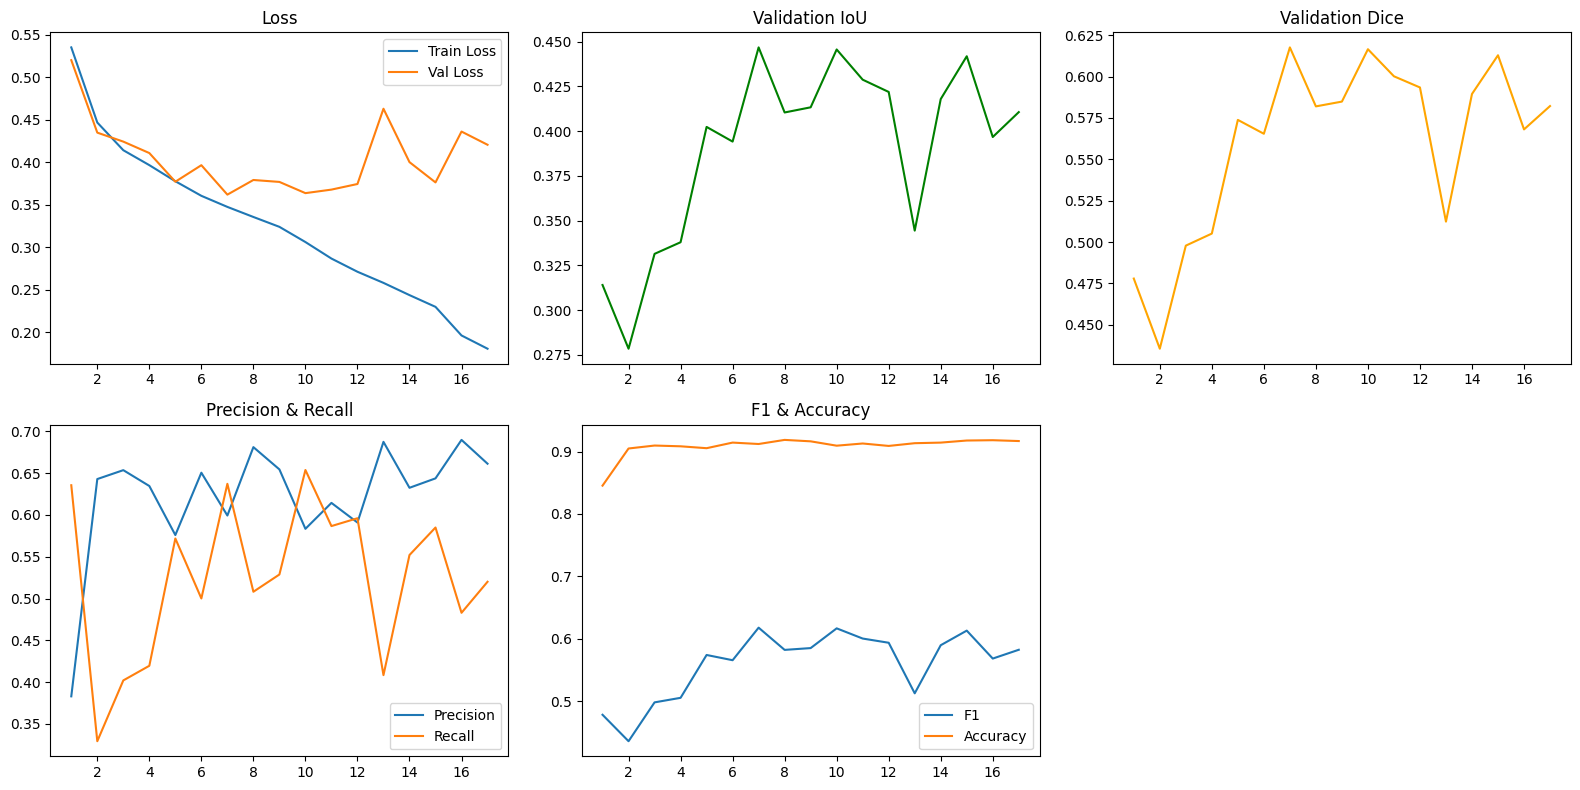

Test Metrics:
                      0
IoU        4.522924e-01
Dice       6.228669e-01
Precision  6.055311e-01
Recall     6.412246e-01
F1         6.228669e-01
Accuracy   9.176794e-01
TP         8.420170e+05
FP         5.485260e+05
FN         4.711220e+05
TN         1.052464e+07


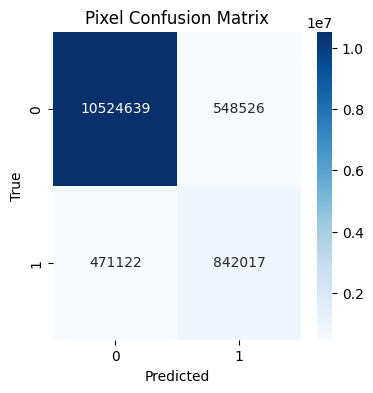

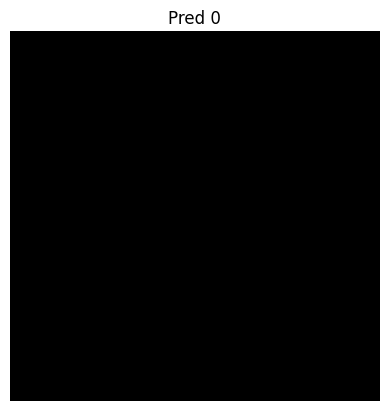

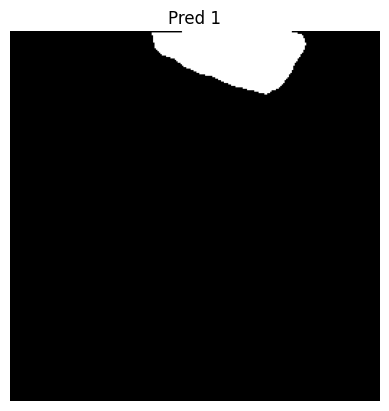

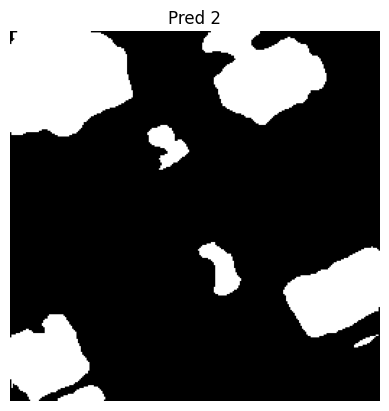

In [6]:
# Visualization for custom U-Net++ results
hist_df = pd.read_csv('training_history_unetpp.csv')
print('History head:')
print(hist_df.head())

fig, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(16,8))
ax1.plot(hist_df['epoch'], hist_df['train_loss'], label='Train Loss')
ax1.plot(hist_df['epoch'], hist_df['val_loss'], label='Val Loss')
ax1.set_title('Loss'); ax1.legend()
ax2.plot(hist_df['epoch'], hist_df['IoU'], label='IoU', color='green')
ax2.set_title('Validation IoU')
ax3.plot(hist_df['epoch'], hist_df['Dice'], label='Dice', color='orange')
ax3.set_title('Validation Dice')
ax4.plot(hist_df['epoch'], hist_df['Precision'], label='Precision')
ax4.plot(hist_df['epoch'], hist_df['Recall'], label='Recall')
ax4.set_title('Precision & Recall'); ax4.legend()
ax5.plot(hist_df['epoch'], hist_df['F1'], label='F1')
ax5.plot(hist_df['epoch'], hist_df['Accuracy'], label='Accuracy')
ax5.set_title('F1 & Accuracy'); ax5.legend()
ax6.axis('off')
plt.tight_layout(); plt.show()

# Load test metrics
metrics_df = pd.read_csv('test_metrics_unetpp.csv')
print('Test Metrics:')
print(metrics_df.T)

# Confusion matrix heatmap
cm = np.loadtxt('confusion_matrix_unetpp.txt', dtype=int)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Pixel Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Show sample predictions
for i in range(3):
    p_path = f'test_predictions_unetpp/pred_{i}.png'
    if os.path.exists(p_path):
        plt.figure()
        plt.imshow(Image.open(p_path), cmap='gray')
        plt.title(f'Pred {i}')
        plt.axis('off')
plt.show()